In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import os
import zipfile
import shutil
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Dataset_Capstone/DATASET/TRAIN',
    labels='inferred',
    label_mode='binary',
    image_size=(120, 120),
    batch_size=128
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Dataset_Capstone/DATASET/TEST',
    labels='inferred',
    label_mode='binary',
    image_size=(120, 120),
    batch_size=128
)


Found 22574 files belonging to 2 classes.
Found 2513 files belonging to 2 classes.


In [4]:
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

test_dataset = (test_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

In [5]:
for images, labels in train_dataset.take(5):
	example_batch_images = images
	example_batch_labels = labels
example_batch_labels[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [6]:
augmentation_model = tf.keras.Sequential([
    tf.keras.Input(shape=(120, 120, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest')])

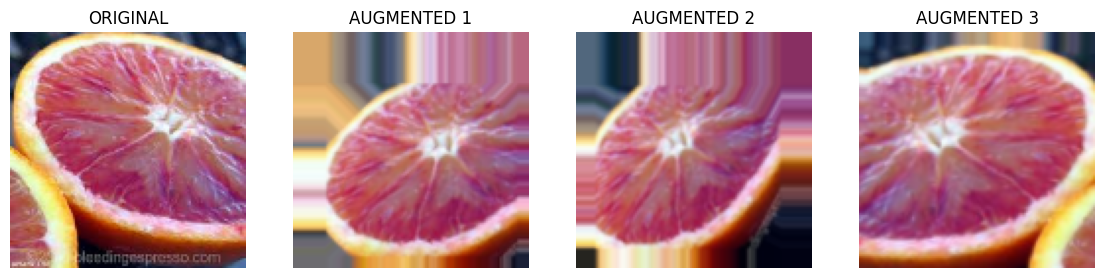

In [7]:
data_augmentor = augmentation_model

sample_image = tf.keras.utils.array_to_img(example_batch_images[120])

images = [sample_image]

for _ in range(3):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)

fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['ORIGINAL', 'AUGMENTED 1', 'AUGMENTED 2', 'AUGMENTED 3']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(120, 120, 3)),
    augmentation_model,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')

])

model.compile(loss = 'sparse_categorical_crossentropy',  optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [9]:
try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (128, 2)


In [10]:

class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):

        if logs['accuracy'] >= 0.8 and logs['val_accuracy'] >= 0.85:
            self.model.stop_training = True

            print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")


In [11]:

history = model.fit(
	train_dataset,
	epochs=10,
	validation_data=test_dataset,
)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1816s 10s/step - accuracy: 0.7160 - loss: 0.6960 - val_accuracy: 0.8396 - val_loss: 0.3697
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1427s 8s/step - accuracy: 0.8101 - loss: 0.4211 - val_accuracy: 0.8571 - val_loss: 0.3536
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1440s 8s/step - accuracy: 0.8223 - loss: 0.3966 - val_accuracy: 0.8623 - val_loss: 0.3392
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1463s 8s/step - accuracy: 0.8272 - loss: 0.3939 - val_accuracy: 0.8659 - val_loss: 0.3351
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1443s 8s/step - accuracy: 0.8311 - loss: 0.3839 - val_accuracy: 0.8571 - val_loss: 0.3430
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1429s 8s/step - accuracy: 0.8403 - loss: 0.3714 - val_accuracy: 0.8579 - val_loss: 0.3470
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1473s 8s/step - accuracy: 0.8426 - loss: 0.3615 - val_accuracy: 0.8500 - val_loss: 0.3975
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1490s 8s/step - accuracy: 0.8444 - loss: 0.3588 -

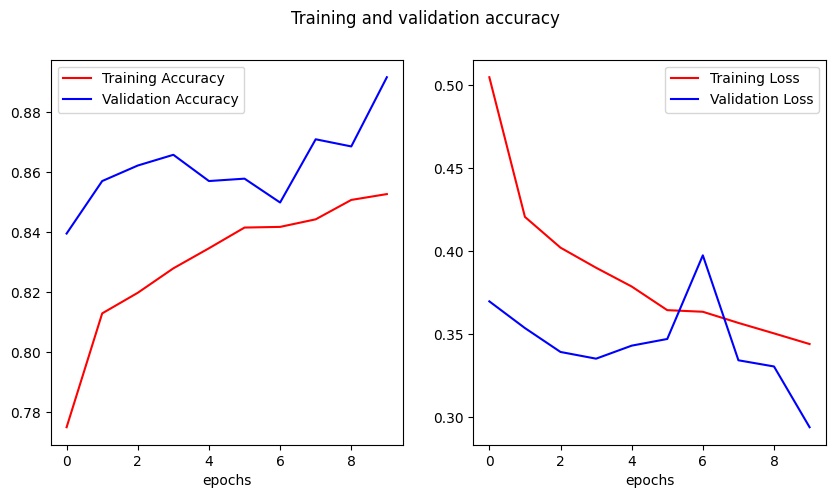

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [13]:
def load_and_preprocess_image(image_path, img_size=(120, 120)):

    img = tf.keras.utils.load_img(image_path, target_size=img_size)

    img_array = tf.keras.utils.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_array = img_array / 255.0
    return img_array

In [14]:
image_path = '/content/drive/MyDrive/Dataset_Capstone/DATASET/DATASET/TRAIN/R/R_9999.jpg'

processed_image = load_and_preprocess_image(image_path)

predictions = model(processed_image)
predicted_class = np.argmax(predictions[0])
print(f"Predicted Class: {predicted_class}")

Predicted Class: 1


In [1]:

!pip install tensorflowjs

import tensorflow as tf

model.save('model_capstone.h5')
print("Model telah disimpan sebagai model_capstone.h5")

output_dir = '/content/drive/MyDrive/tfjs_model'

!tensorflowjs_converter --input_format=keras model_capstone.h5 {output_dir}

print(f"Model telah dikonversi ke format TensorFlow.js di: {output_dir}")


NameError: name 'model' is not defined